# Import Required Libraries

In [1]:
from scipy.spatial import distance as dist
import cv2  
import dlib  # for face and landmark detection
import imutils
from imutils import face_utils
import urllib.request
import bz2
import os
import matplotlib.pyplot as plt
import zipfile
import numpy as np

In [2]:
# testing path..
video_path = os.path.abspath("../DATA/drunk_male_1.mp4")

# checking existance
if not os.path.exists(video_path):
    print("Error: Video file not found.")
else:
    print("Video file found:", video_path)

Video file found: /home/michelle/Drunk_Detector/DATA/drunk_male_1.mp4


In [3]:
os.getcwd()

'/home/michelle/Drunk_Detector/src'

# Functions to Load Data and Calculate EARs

In [4]:
def calculate_EAR(eye):
    """
    : calculates EAR values(Eye Aspect Ratio)
    
    [params]
    - eye: landmark values
    
    [return]
    - ear: eye aspect ratio
    """
    A = np.linalg.norm(eye[1] - eye[5])
    B = np.linalg.norm(eye[2] - eye[4])
    C = np.linalg.norm(eye[0] - eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

In [5]:
def process_video(video_path, detector, predictor, L_start, L_end, R_start, R_end):
    """
    : read videos and calculate EAR in each frame then return EAR sequential arrays
    
    [params]
    - video_path: path to your dataset
    - detector: dlib.get_frontal_face_detector()
    - predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    - L_start: start index of left eye landmarks (typically 42)
    - L_end: end index of left eye landmarks (typically 47)
    - R_start: start index of right eye landmarks (typically 36)
    - R_end: end index of right eye landmarks (typically 41)
    
    [return]
    - ear_sequence: ear_sequence of a video that is cut off padded with zero to match length 1800
    """
    cam = cv2.VideoCapture(video_path)
    if not cam.isOpened():
        print(f"Error: Could not open video {video_path}")
        return None

    ear_sequence = []
    while True:
        ret, frame = cam.read()
        if not ret:
            print(f"No more frames in video {video_path}")
            break

        frame = imutils.resize(frame, width=640)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        faces = detector(gray)
        for face in faces:
            shape = predictor(gray, face)
            shape = face_utils.shape_to_np(shape)

            lefteye = shape[L_start:L_end]
            righteye = shape[R_start:R_end]

            left_EAR = calculate_EAR(lefteye)
            right_EAR = calculate_EAR(righteye)
            avg_EAR = (left_EAR + right_EAR) / 2.0
            ear_sequence.append(avg_EAR)

    cam.release()
    # fixed length of ear_sequence -> cut off or pad with 0 
    if len(ear_sequence) < 1800: 
        ear_sequence += [0] * (1800 - len(ear_sequence))
    
    return np.array(ear_sequence[:1800])

In [6]:
def load_data_with_filenames(data_dir, detector, predictor, L_start, L_end, R_start, R_end):
    """
    : processes each video to create a dataset with EAR sequences (X) and corresponding labels (y), where {"drunk": 1, "sober": 0}
    : generates a list of video filenames for future use (creating a csv file with data split information)
    
    [params]
    - data_dir: path to your dataset
    - detector: dlib.get_frontal_face_detector()
    - predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    - L_start: start index of left eye landmarks (typically 42)
    - L_end: end index of left eye landmarks (typically 47)
    - R_start: start index of right eye landmarks (typically 36)
    - R_end: end index of right eye landmarks (typically 41)
    
    [return]
    - np.array(X): EAR sequences
    - np.array(y): corresponding labels where {"drunk": 1, "sober": 0}
    - filenames: list of each video's file names
    """
    X, y, filenames = [], [], []
    label_dirs = {"drunk": 1, "sober": 0}

    for label, value in label_dirs.items():
        label_path = os.path.join(data_dir, "video", label)  # each label's path

        for subdir in ["female", "male"]:  
            full_path = os.path.join(label_path, subdir)
            if not os.path.exists(full_path):  
                continue

            video_files = [f for f in os.listdir(full_path) if f.endswith('.mp4')]
            selected_videos = sorted(video_files)  

            for video_file in selected_videos:
                video_path = os.path.join(full_path, video_file)
                ear_sequence = process_video(video_path, detector, predictor, L_start, L_end, R_start, R_end)

                if ear_sequence is not None:  
                    X.append(ear_sequence)
                    y.append(value)
                    filenames.append(video_file) 
    
    return np.array(X), np.array(y), filenames

In [7]:
# absolute path
data_dir = os.path.abspath("../DATA/DATA")  

In [8]:
# dlib detects face and eye landmarks which allows us to calculate EARs
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
(L_start, L_end) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(R_start, R_end) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

# Load Data

In [9]:
X, y, filenames = load_data_with_filenames(data_dir, detector, predictor, L_start, L_end, R_start, R_end)

No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_01.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_02.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_03.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_04.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_05.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_06.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_07.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_08.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/drunk/female/drunk_female_09.mp4
No more frames in video /home/michelle/Drunk_Detector/DATA/DATA/video/dru

# Split Data and Get Ready For Training

In [10]:
from sklearn.model_selection import train_test_split

# train:val:test=7:2:1
X_train, X_temp, y_train, y_temp, train_files, temp_files = train_test_split(X, y, filenames, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test, val_files, test_files = train_test_split(X_temp, y_temp, temp_files, test_size=0.33, random_state=42)

# check results
print(f"Train set: {len(X_train)}, Validation set: {len(X_val)}, Test set: {len(X_test)}")

print("Train files:", train_files)
print("Validation files:", val_files)
print("Test files:", test_files)

print(f"Train set: {len(X_train)}, Validation set: {len(X_val)}, Test set: {len(X_test)}")

Train set: 81, Validation set: 23, Test set: 12
Train files: ['drunk_female_10.mp4', 'drunk_male_05.mp4', 'sober_female_07.mp4', 'sober_female_09.mp4', 'drunk_female_29.mp4', 'drunk_male_16.mp4', 'sober_male_25.mp4', 'drunk_female_06.mp4', 'sober_male_09.mp4', 'sober_female_08.mp4', 'drunk_male_11.mp4', 'drunk_male_07.mp4', 'drunk_female_17.mp4', 'sober_female_15.mp4', 'drunk_male_06.mp4', 'sober_female_16.mp4', 'drunk_female_08.mp4', 'drunk_male_15.mp4', 'sober_female_12.mp4', 'sober_female_19.mp4', 'drunk_female_28.mp4', 'drunk_female_20.mp4', 'sober_male_27.mp4', 'sober_male_11.mp4', 'drunk_female_26.mp4', 'drunk_female_09.mp4', 'sober_male_19.mp4', 'drunk_male_21.mp4', 'drunk_female_14.mp4', 'sober_female_24.mp4', 'drunk_female_04.mp4', 'drunk_female_18.mp4', 'drunk_male_10.mp4', 'sober_male_03.mp4', 'drunk_female_07.mp4', 'sober_male_17.mp4', 'sober_male_15.mp4', 'sober_male_05.mp4', 'drunk_male_26.mp4', 'drunk_male_22.mp4', 'sober_female_20.mp4', 'drunk_male_18.mp4', 'sober_femal

In [11]:
# reshape for LSTM inputs
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [12]:
import keras_tuner

2024-11-07 13:41:53.227144: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Hyperparameter Tuning

In [13]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner import Hyperband

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # run on CPU, not GPU

def build_model(hp):
    """
    : builds model
    [param]
    - hp: hyperparameters
    [return]
    - model: each model 
    """
    model = Sequential()
    
    for i in range(hp.Int('conv_layers', 1, 3)):  
        model.add(Conv1D(
            filters=hp.Int(f'filters_{i}', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice(f'kernel_size_{i}', values=[3, 5]),
            activation='relu',
            input_shape=(1800, 1) if i == 0 else None
        ))
    
    model.add(LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [14]:
# Hyperband 설정
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='hyperband_dir',
    project_name='drunk_detection_tuning',
    overwrite=True
)

# Callbacks
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# 총 Trial 수 계산
tuner.search_space_summary()
total_trials = tuner.oracle.max_trials
print(f"Total number of trials: {total_trials}")

# 하이퍼파라미터 검색 (현재 Trial 상태 출력)
class TuningProgressCallback(tf.keras.callbacks.Callback):
    def on_trial_begin(self, trial):
        current_trial = len(tuner.oracle.trials)  # 현재 Trial 수 가져오기
        print(f"Starting trial {current_trial} of {total_trials}")

# search for the best parameters
history = tuner.search(X_train, y_train, batch_size=4, validation_data=(X_val, y_val), callbacks=[stop_early])

Trial 30 Complete [00h 05m 03s]
val_accuracy: 0.6086956262588501

Best val_accuracy So Far: 0.6086956262588501
Total elapsed time: 01h 21m 59s


In [15]:
data = []

for trial in tuner.oracle.trials.values():
    trial_data = trial.hyperparameters.values
    trial_data['val_accuracy'] = trial.metrics.get_last_value('val_accuracy')
    trial_data['val_loss'] = trial.metrics.get_last_value('val_loss')
    data.append(trial_data)

df = pd.DataFrame(data)

print("All Hyperparameter Combinations and Their Validation Scores:")
df

All Hyperparameter Combinations and Their Validation Scores:


,conv_layers,filters_0,kernel_size_0,lstm_units,dropout_rate,learning_rate,tuner/epochs,tuner/initial_epoch,tuner/bracket,tuner/round,filters_1,kernel_size_1,filters_2,kernel_size_2,val_accuracy,val_loss,tuner/trial_id
0,3,32,3,96,0.4,0.000723,3,0,2,0,32,3,32,3,0.478261,0.694739,NaN
1,3,96,3,128,0.2,0.000532,3,0,2,0,96,3,96,5,0.608696,0.689066,NaN
2,2,128,5,32,0.4,0.000573,3,0,2,0,128,3,64,5,0.608696,0.688295,NaN
3,1,96,3,32,0.4,0.003534,3,0,2,0,128,3,64,5,0.608696,0.684810,NaN
4,2,64,3,32,0.2,0.005399,3,0,2,0,128,5,64,5,0.478261,0.705701,NaN
5,1,32,3,96,0.3,0.007088,3,0,2,0,96,5,32,3,0.521739,0.691344,NaN
6,3,32,5,32,0.2,0.000243,3,0,2,0,32,5,32,3,0.478261,0.693748,NaN
7,2,64,5,96,0.3,0.000241,3,0,2,0,64,5,32,3,0.608696,0.691416,NaN
8,1,64,5,128,0.5,0.005015,3,0,2,0,64,3,128,3,0.608696,0.684275,NaN
9,3,32,5,64,0.5,0.001454,3,0,2,0,32,5,64,3,0.608696,0.681930,NaN


In [17]:
# Best Hyperparameters based on Minimum Validation Loss
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters based on Minimum Validation Loss:")
print(best_hyperparameters)

Best Hyperparameters based on Minimum Validation Loss:


In [18]:
# build the best model based on the best hyperparamters
best_model = build_model(best_hyperparameters)
best_model.summary()

/home/michelle/project1/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 1798, 96)       │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1796, 96)       │        27,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1792, 96)       │        46,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,633 (740.75 KB)

 Trainable params: 189,633 (740.75 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
best_hyperparameters.values

{'conv_layers': 3,
 'filters_0': 96,
 'kernel_size_0': 3,
 'lstm_units': 128,
 'dropout_rate': 0.2,
 'learning_rate': 0.0005318904448087574,
 'filters_1': 96,
 'kernel_size_1': 3,
 'filters_2': 96,
 'kernel_size_2': 5,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0,
 'val_accuracy': np.float64(0.6086956262588501),
 'val_loss': np.float64(0.6890661120414734)}

In [20]:
# 최적의 에포크 수 가져오기 (없을 경우 기본값 10 설정)
epochs = best_hyperparameters.values.get('tuner/epochs', 10)

# fit again
best_model.fit(X_train, y_train, epochs=epochs, batch_size=4, validation_data=(X_val, y_val), callbacks=[stop_early])

Epoch 1/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5511 - loss: 0.6941 - val_accuracy: 0.6087 - val_loss: 0.6893
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.4647 - loss: 0.6927 - val_accuracy: 0.6087 - val_loss: 0.6836
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5531 - loss: 0.6898 - val_accuracy: 0.6087 - val_loss: 0.6594


In [21]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, matthews_corrcoef

y_pred_probs = best_model.predict(X_test)  
y_pred_classes = (y_pred_probs > 0.5).astype(int)  

print("Predictions for Test Set")
for i in range(len(X_test)):
    print(f"Video {test_files[i]}: Prediction Probability = {y_pred_probs[i][0]:.4f}, Predicted Class = {y_pred_classes[i][0]}, Actual Class = {y_test[i]}")

# metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
auc = roc_auc_score(y_test, y_pred_probs)
mcc = matthews_corrcoef(y_test, y_pred_classes)

print("\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"MCC: {mcc:.4f}")

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
Predictions for Test Set
Video drunk_male_03.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 1
Video drunk_male_25.mp4: Prediction Probability = 0.4867, Predicted Class = 0, Actual Class = 1
Video drunk_female_16.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 1
Video sober_male_02.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 0
Video drunk_female_01.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 1
Video drunk_female_23.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 1
Video sober_male_14.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 0
Video sober_male_08.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 0
Video sober_female_13.mp4: Prediction Probability = 0.4848, Predicted Class = 0, Actual Class = 0
Video drunk_male_28.mp4: Prediction Probability = 0.4848, Predic

/home/michelle/project1/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step - accuracy: 0.3333 - loss: 0.7034

Test Loss: 0.7034
Test Accuracy: 0.3333


# Saving Outputs

In [22]:
output = pd.DataFrame({'Video':test_files,'Prediction Probability': y_pred_probs[:,0], 'Predicted Class': y_pred_classes[:,0], 'Actual Class':y_test})

In [23]:
output.to_csv('final_prediction_output.csv')

In [24]:
file_labels = []

for filename in filenames:
    if filename in train_files:
        file_labels.append('train')
    elif filename in val_files:
        file_labels.append('val')
    elif filename in test_files:
        file_labels.append('test')
    else:
        print(f'{filename} not in any filenames')

In [25]:
data_split = pd.DataFrame({'Video': filenames, 'label': file_labels})

In [26]:
data_split.to_csv('final_data_split.csv')

# Further Analysis on Our Dataset, Reason Why Our Model Might Be Showing Poor Results

In [44]:
EAR_mean = []
EAR_min = []
EAR_max = []
for i in range(len(X_train)):
    EAR_mean.append(np.mean(X_train[i]))
    EAR_min.append(np.min(X_train[i]))
    EAR_max.append(np.max(X_train[i]))

In [45]:
print(f'EAR mean={np.mean(EAR_mean)}')
print(f'EAR mean of minimum={np.mean(EAR_min)}')
print(f'EAR mean of maximum={np.mean(EAR_max)}')
print(f'Standard Deviation of EAR_mean={np.std(EAR_min)}')

EAR mean=0.14412466563122905
EAR mean of minimum=0.0020924671344046413
EAR mean of maximum=0.4625446760494299
Standard Deviation of EAR_mean=0.011995260587663132


In [51]:
# X: 모든 영상 각각에 대한 EAR 정보 담고 있음
drunk_EAR_means = []
sober_EAR_means = []
for i in range(len(X)):
    if y[i]==1: # drunk
        drunk_EAR_means.append(np.mean(X[i]))
    else: # sober
        sober_EAR_means.append(np.mean(X[i]))

In [64]:
print('[drunk_EAR_means]')
print('* mean = {:.4f}'.format(np.mean(drunk_EAR_means)))
print('* std = {:.4f}'.format(np.std(drunk_EAR_means)))
plt.ylabel("Density")
print('[sober_EAR_means]')
print('* mean = {:.4f}'.format(np.mean(sober_EAR_means)))
print('* std = {:.4f}'.format(np.std(sober_EAR_means)))

[drunk_EAR_means]
* mean = 0.1527
* std = 0.0609

[sober_EAR_means]
* mean = 0.1326
* std = 0.0852


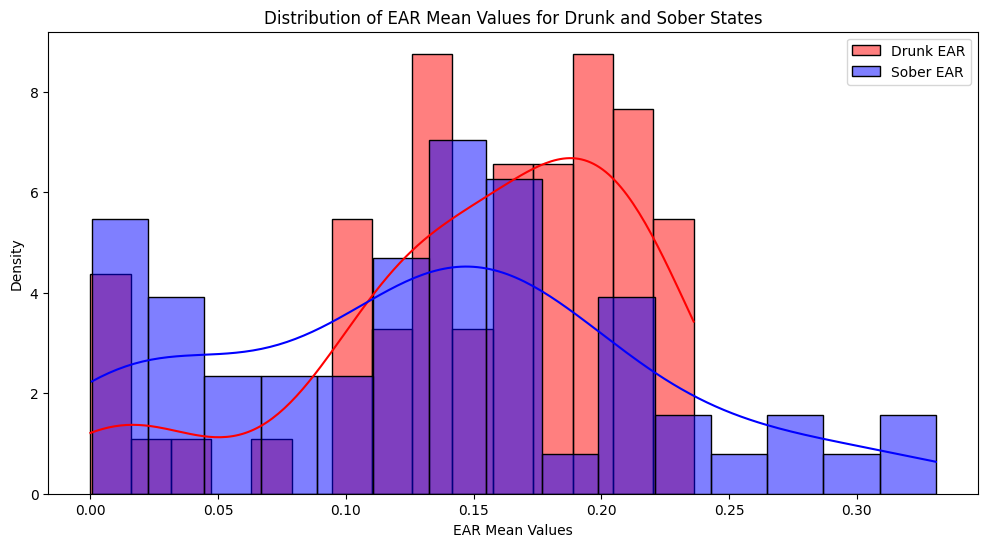

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
# drunk_EAR_means
sns.histplot(drunk_EAR_means, color="red", kde=True, label="Drunk EAR", bins=15, stat="density", alpha=0.5)
# sober_EAR_means
sns.histplot(sober_EAR_means, color="blue", kde=True, label="Sober EAR", bins=15, stat="density", alpha=0.5)

plt.xlabel("EAR Mean Values")
plt.ylabel("Density")
plt.title("Distribution of EAR Mean Values for Drunk and Sober States")
plt.legend()
plt.show()